In [25]:
# 1D CNN
from scipy.signal import butter, lfilter
from scipy.signal import freqz

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [27]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np

In [28]:
# replace with a google drive link
# df = pd.read_csv('Book1.csv')
df_train = pd.read_csv('resampled_data.csv')
# df = df[df['expert_consensus'] != 'Other']
TARGETS = df_train.columns[-5]
print('Train entries shape', df_train.shape)
# display(df_train.head())

# read a test dataframe
df_all = pd.read_csv('filtered_train.csv')
merged_df = pd.merge(df_all, df_train, on=['eeg_id', 'eeg_sub_id'], how='left', indicator=True)

# Filter rows that exist only in df_all
unique_in_df_all = merged_df[merged_df['_merge'] == 'left_only']

# Select the first 100 rows from these unique rows
result = unique_in_df_all.head(300)

# Drop the merge indicator column if no longer needed
df1 = result.drop(columns=['_merge'])
df_selected = df1.iloc[:, 1:10]
rename_dict = {'eeg_label_offset_seconds_x': 'eeg_label_offset_seconds', 'spectrogram_id_x': 'spectrogram_id', 
'spectrogram_sub_id_x':'spectrogram_sub_id','spectrogram_label_offset_seconds_x':'spectrogram_label_offset_seconds',
'label_id_x':'label_id', 'patient_id_x':'patient_id', 'expert_consensus_x':'expert_consensus'}
# Rename columns using the dictionary
df_test = df_selected.rename(columns=rename_dict)

# display(df_test.head())
print('Test entries shape', df_test.shape)

Train entries shape (1352, 14)
Test entries shape (300, 9)


In [29]:
def select_random_row(group):
    return group.sample(n=1)

def process_csv_into_dataframe(df):
    train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
        {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
    train.columns = ['spec_id','min_spec_sec']

    tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
        {'spectrogram_label_offset_seconds':'max'})
    train['max_spec_sec'] = tmp

    # this is unnecessary because we don't need patient id to train
    consensus_df = df[['eeg_id', 'expert_consensus']].drop_duplicates(subset='eeg_id', keep='first')
    train = train.merge(consensus_df, on='eeg_id', how='left')

    df_sub_id = df[['eeg_id','eeg_sub_id', 'eeg_label_offset_seconds']]
    eeg_with_one_subid = df_sub_id.groupby('eeg_id', as_index=False).apply(select_random_row).reset_index(drop=True)

    train = pd.merge(train, eeg_with_one_subid, on='eeg_id', how='left')
    train = train.reset_index()
    return train

train = process_csv_into_dataframe(df_train)
test = process_csv_into_dataframe(df_test)
print('Train non-overlapp eeg_id shape:', train.shape)
train.head()
print('test non-overlapp eeg_id shape:', test.shape)
test.head()

Train non-overlapp eeg_id shape: (550, 8)
test non-overlapp eeg_id shape: (85, 8)


C:\Users\SatoruGojo\AppData\Local\Temp\ipykernel_2312\2440270020.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eeg_with_one_subid = df_sub_id.groupby('eeg_id', as_index=False).apply(select_random_row).reset_index(drop=True)
C:\Users\SatoruGojo\AppData\Local\Temp\ipykernel_2312\2440270020.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eeg_with_one_subid = df_sub_id.groupby('eeg_id', as_index=Fal

,index,eeg_id,spec_id,min_spec_sec,max_spec_sec,expert_consensus,eeg_sub_id,eeg_label_offset_seconds
0,0,52835146,313593792,1234.0,1242.0,GPD,3,8.0
1,1,142529460,386828807,2.0,2.0,LPD,1,2.0
2,2,159467578,216247047,0.0,0.0,Other,0,0.0
3,3,206288746,404903818,0.0,4.0,Other,2,4.0
4,4,279037225,102693150,0.0,6.0,Other,2,6.0


In [30]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# TODO: after uploading to colab, replace with my google drive folder
PATH = 'subset_train_eegs/'
# PATH = 'subset_train_eegs_compare/'

In [31]:
def quantize_data(data, classes):
    data = data-data.mean()
    data = data/(abs(data).max())
    mu_x = mu_law_encoding(data, classes)
    return mu_x

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 5.0
    highcut = 40.0
    # Filter a noisy signal.
    # T = 50
    # nsamples = T * fs
    # t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    return y

In [32]:
import random

# all_eegs1 = {}
all_eegs2 = {}
for idx in tqdm(range(len(train))):
    row = train.iloc[idx]
    eeg_id = row['eeg_id']
    eeg_sub_id = row['eeg_sub_id']
    parq_path = f'{PATH}{eeg_id}.parquet'
    eeg = pd.read_parquet(parq_path)
    start = int(row['eeg_label_offset_seconds']*200)
    eeg = eeg.iloc[start:start+10000]
    eeg = eeg.fillna(0)
    
    eeg = eeg.drop(['Fz', 'Cz','Pz','EKG'], axis=1)
    signals1 = []
    signals2 = []
    for k in range(4):
            COLS = FEATS[k]
            for j in range(4):
                x = eeg[COLS[j]].values - eeg[COLS[j+1]].values
                signals1.append(x)
                x = denoise_filter(x)
                x = quantize_data(x,1)
                signals2.append(x)
                
    signals1 = np.array(signals1,dtype='float32')
    signals2 = np.array(signals2,dtype='float32')
    
    # all_eegs1[f'{eeg_id}_{eeg_sub_id}'] = signals1
    all_eegs2[f'{eeg_id}_{eeg_sub_id}'] = signals2


# np.save('16_waves_eeg_specs_partial_train',all_eegs1)
np.save('16_waves_eeg_specs_partial_train_quantize',all_eegs2)

  0%|          | 0/550 [00:00<?, ?it/s]

100%|██████████| 550/550 [00:10<00:00, 52.93it/s]


In [48]:
import random

all_eegs2_test = {}
for idx in tqdm(range(len(test))):
    row = test.iloc[idx]
    eeg_id = row['eeg_id']
    eeg_sub_id = row['eeg_sub_id']
    parq_path = f'{PATH}{eeg_id}.parquet'
    eeg = pd.read_parquet(parq_path)
    start = int(row['eeg_label_offset_seconds']*200)
    eeg = eeg.iloc[start:start+10000]
    eeg = eeg.fillna(0)
    
    eeg = eeg.drop(['Fz', 'Cz','Pz','EKG'], axis=1)
    
    signals2 = []
    for k in range(4):
            COLS = FEATS[k]
            for j in range(4):
                x = eeg[COLS[j]].values - eeg[COLS[j+1]].values
                x = denoise_filter(x)
                x = quantize_data(x,1)
                signals2.append(x)
                
    signals2 = np.array(signals2,dtype='float32')
    all_eegs2_test[f'{eeg_id}_{eeg_sub_id}'] = signals2


np.save('16_waves_eeg_specs_partial_test_quantize',all_eegs2_test)

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:01<00:00, 53.94it/s]


In [34]:
unique_names = train['expert_consensus'].unique()
unique_names

array(['LPD', 'Seizure', 'Other', 'GPD'], dtype=object)

In [35]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        # if training:
        self.eegs_data = np.load('16_waves_eeg_specs_partial_train_quantize.npy',allow_pickle=True).item()
        # self.seizure_to_id = {'Seizure':0,'GPD':1,'LPD':2,'LRDA':3,'GRDA':4, 'Other':5}
        self.seizure_to_id = {'Seizure':0,'GPD':1,'LPD':2,'Other':3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        eeg_id = row['eeg_id']
        eeg_sub_id = row['eeg_sub_id']
        eeg_key = f'{eeg_id}_{eeg_sub_id}'
        signals = self.eegs_data[eeg_key]   # 16*2500
        label = self.seizure_to_id[row['expert_consensus']]
        return torch.tensor(signals,dtype=torch.float64), torch.tensor(label,dtype=torch.float64)

In [52]:
class CustomDatasetTest(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        # if training:
        self.eegs_data = np.load('16_waves_eeg_specs_partial_test_quantize.npy',allow_pickle=True).item()
        # self.seizure_to_id = {'Seizure':0,'GPD':1,'LPD':2,'LRDA':3,'GRDA':4, 'Other':5}
        self.seizure_to_id = {'Seizure':0,'GPD':1,'LPD':2,'Other':3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        eeg_id = row['eeg_id']
        eeg_sub_id = row['eeg_sub_id']
        eeg_key = f'{eeg_id}_{eeg_sub_id}'

        signals = self.eegs_data[eeg_key] 
        label = self.seizure_to_id[row['expert_consensus']]
        return torch.tensor(signals,dtype=torch.float64), torch.tensor(label,dtype=torch.float64)

In [37]:
class CNN1D(nn.Module):
    def __init__(self,in_channels):
        super(CNN1D, self).__init__()
        self.hidden_channels = 128
        self.conv1 = nn.Conv1d(in_channels, 64, 20, 10)
        self.conv2 = nn.Conv1d(64, 64, 10, 5)
        self.conv3 = nn.Conv1d(64, 64, 12, 4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(640, 32)
        self.fc2 = nn.Linear(32, 5)  
        self.softmax = nn.Softmax(dim=1)
        # self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x =nn.LeakyReLU(0.01)(self.conv1(x))
        # x = self.dropout(x)
        x = nn.LeakyReLU(0.01)(self.conv2(x))
        # x = self.dropout(x)
        x = nn.LeakyReLU(0.01)(self.conv3(x))
        # x = self.dropout(x)
        x = (self.flatten(x))
        # TODO: sample the 640 long vector from the from the convolution
        localized_feature = x
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x,localized_feature

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
train_dataset = CustomDataset(dataframe=train)
test_dataset = CustomDatasetTest(dataframe=test)
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, and optimizer
model = CNN1D(in_channels=16).double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and evaluation
epochs = 90
train_acc = []
test_acc = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    if epoch==epochs-1:
        # list of tensors
        localized_features_high_dim_arr = []    # size 256*640 or 38*640 tensors
        true_label_arr = [] # size 256 or 38 tensors
        predicted_label_arr = []     # same
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

    for batch in pbar:
        eeg_, label = batch
        pred, feature_map = model(eeg_.to(device))

        loss = criterion(pred, label.long().to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_labels = torch.max(pred, 1)
        correct_predictions += (predicted_labels == label.to(device)).sum().item()
        total_predictions += label.size(0)

        if epoch==epochs-1:
            localized_features_high_dim_arr.append(feature_map)
            true_label_arr.append(label)
            predicted_label_arr.append(predicted_labels)

    train_epoch_loss = running_loss / len(train_dataloader)
    train_epoch_accuracy = correct_predictions / total_predictions * 100
    train_acc.append(train_epoch_accuracy)

    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for eeg_, label in test_dataloader:
            pred,_ = model(eeg_.to(device))
            loss = criterion(pred, label.long().to(device))
            test_loss += loss.item()
            _, predicted_labels = torch.max(pred, 1)
            correct += (predicted_labels == label.to(device)).sum().item()
            total += label.size(0)

    test_epoch_loss = test_loss / len(test_dataloader)
    test_epoch_accuracy = correct / total * 100
    test_acc.append(test_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%")
    print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%")

localized_features_high_dim_all = torch.cat(localized_features_high_dim_arr, dim=0).detach().numpy()
true_label_all = torch.cat(true_label_arr, dim=0).detach().numpy()
predicted_label_all = torch.cat(predicted_label_arr, dim=0).detach().numpy()

print(localized_features_high_dim_all.shape)
print(true_label_all.shape)
print(predicted_label_all.shape)


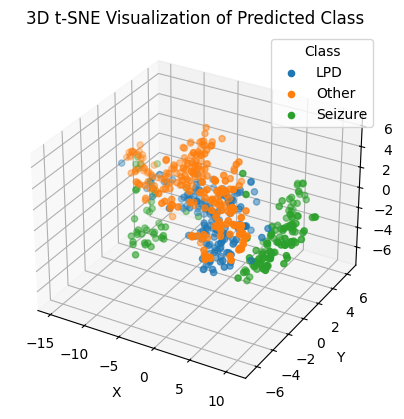

In [35]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne_3d = TSNE(n_components=3)
X = localized_features_high_dim_all

tsne3d_projections = tsne_3d.fit_transform(X)
plotting_df1 = pd.DataFrame(tsne3d_projections, columns=['X','Y','Z'])
plotting_df1['predicted_label'] = predicted_label_all

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
label_to_description = {0: 'Seizure', 1: 'GPD', 2: 'LPD', 3: 'Other'}

for class_label in plotting_df1['predicted_label'].unique():
    class_points = plotting_df1[plotting_df1['predicted_label'] == class_label]
    ax.scatter(class_points['X'], class_points['Y'], class_points['Z'],  label=label_to_description[class_label])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(title='Class')
ax.set_title('3D t-SNE Visualization of Predicted Class')
plt.show()

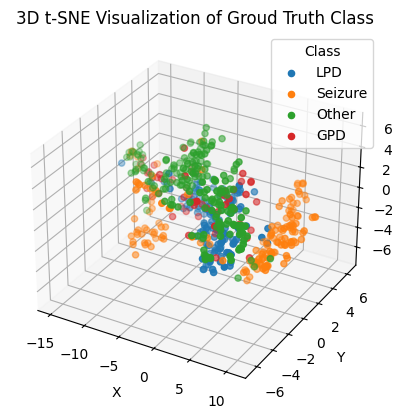

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne_3d = TSNE(n_components=3)
X = localized_features_high_dim_all

tsne3d_projections = tsne_3d.fit_transform(X)
plotting_df1 = pd.DataFrame(tsne3d_projections, columns=['X','Y','Z'])
plotting_df1['true_label'] = true_label_all

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
label_to_description = {0: 'Seizure', 1: 'GPD', 2: 'LPD', 3: 'Other'}

for class_label in plotting_df1['true_label'].unique():
    class_points = plotting_df1[plotting_df1['true_label'] == class_label]
    ax.scatter(class_points['X'], class_points['Y'], class_points['Z'],  label=label_to_description[class_label])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(title='Class')
ax.set_title('3D t-SNE Visualization of Groud Truth Class')

plt.show()

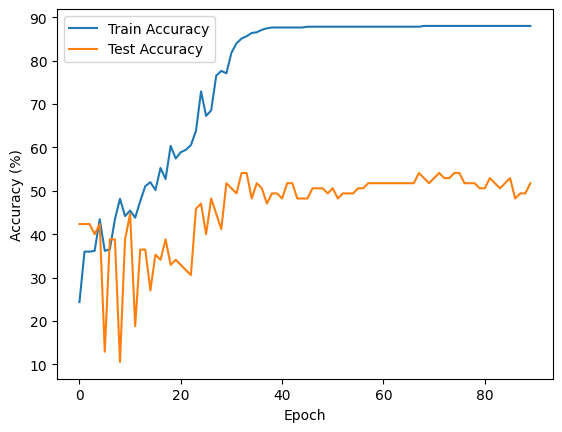

In [54]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()
